1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



[28.09 22.46 26.65 26.65 28.79 30.19 26.19 26.75 23.34 24.16 29.75 27.93
 26.68 23.85 32.97 25.79 26.37 25.28 26.73 23.2  26.76]
Storm wind speed occuring every 50 years is guessed as:  32.97989844019469


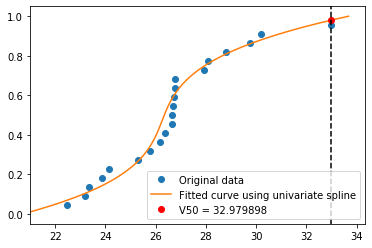

In [2]:
import numpy as np
#loading the data of max speeds
max_speeds = np.load('max-speeds.npy')
print(max_speeds)

#Finding the number of years
years_nb = max_speeds.shape[0] #21 years
#print(years_nb)

#The years in cumulative form till 21 years
years_array = np.arange(1,years_nb+1)
#print(years_array)

#Cumulative probability: p_i = i/(N+1), with N=21
cprob = years_array/(years_nb+1)
#print(cprob)

sorted_max_speeds = np.sort(max_speeds)
#print(sorted_max_speeds)

from scipy.interpolate import UnivariateSpline
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)

fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print("Storm wind speed occuring every 50 years is guessed as: ",fifty_wind)

# Plotting the curve fit
import matplotlib.pyplot as plt

prob_values = np.linspace(0,1,100)
fitted_max_speeds = quantile_func(prob_values)
plt.plot(sorted_max_speeds,cprob,'o',label="Original data")
plt.plot(fitted_max_speeds,prob_values,'-',label="Fitted curve using univariate spline")
plt.plot(fifty_wind,fifty_prob,'ro',label='V50 = %f'%(fifty_wind))
plt.axvline(x=fifty_wind,color='k',linestyle='--')
plt.xlim(left=21)
plt.legend(loc='best')
plt.show()

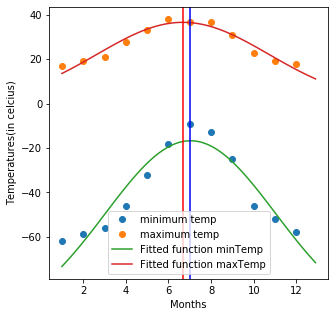

We see that using Gaussian function for curve fitting is not the exact for both minTemp and MaxTemp curve fitting 

Min temp. time offset(blue vertical line): 7.000000000000005
Max temp. time offset(red vertical line): 6.700000000000005
We also see that the time offset for min and max temperatures are not same within the fit accuracy.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize,exp

maxTemp = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
minTemp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
minTemp_scaled = minTemp + 100
months = np.arange(1,13,1)
#months = np.array(['Jan','Feb','Mar','Apr','May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

#fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
plt.figure(figsize=(5,5))
plt.plot(months,minTemp,'o',label='minimum temp')
plt.plot(months,maxTemp,'o',label='maximum temp')
plt.xlabel('Months')
plt.ylabel('Temperatures(in celcius)')

#The scatter plot looks more like a Gaussian. So we define a Gaussian function to fit it 
#and we get the parameters through curve fit
def gaus(x,a,mu,sigma):
    return a*exp(-(x-mu)**2/(2*sigma**2))

param_minTemp,pcov = optimize.curve_fit(gaus,months,minTemp_scaled)#p0=[1,minTemp_mean_guess,minTemp_sigma_guess])
param_maxTemp,pcov = optimize.curve_fit(gaus,months,maxTemp)#p0=[1,maxTemp_mean_guess,maxTemp_sigma_guess])

x_data = np.arange(1,13,0.1)
y_data_minTemp = gaus(x_data, param_minTemp[0], param_minTemp[1], param_minTemp[2])-100
y_data_maxTemp = gaus(x_data, param_maxTemp[0], param_maxTemp[1], param_maxTemp[2])

plt.plot(x_data, y_data_minTemp, label='Fitted function minTemp')
plt.plot(x_data, y_data_maxTemp, label='Fitted function maxTemp')

plt.axvline(x_data[np.argmax(y_data_minTemp)],color="b")#argmax() returns the value of the index of the maximum of the given array
plt.axvline(x_data[np.argmax(y_data_maxTemp)],color="r")

plt.legend(loc='best')
plt.show()

print("We see that using Gaussian function for curve fitting is not the exact for both minTemp and MaxTemp curve fitting ")
print('\nMin temp. time offset(blue vertical line):',x_data[np.argmax(y_data_minTemp)])
print('Max temp. time offset(red vertical line):',x_data[np.argmax(y_data_maxTemp)])
print("We also see that the time offset for min and max temperatures are not same within the fit accuracy.")

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

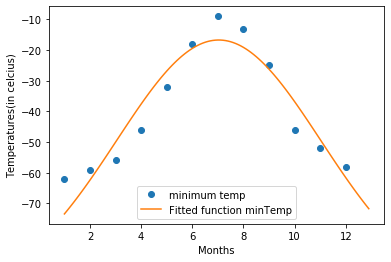

In [4]:
#ROUGH WORK ON THE PREVIOUS PROBLEM
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize,exp

minTemp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
minTemp_scaled = minTemp + 100
months = np.arange(1,13,1)
#months = np.array(['Jan','Feb','Mar','Apr','May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

#fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

plt.plot(months,minTemp,'o',label='minimum temp')
plt.xlabel('Months')
plt.ylabel('Temperatures(in celcius)')

#The scatter plot looks more like a Gaussian. So we define a Gaussian function to fit it 
#and we get the parameters through curve fit

n = len(minTemp)                          #the number of data
def gaus(x,a,mu,sigma):
    return a*exp(-(x-mu)**2/(2*sigma**2))

param_minTemp,pcov = optimize.curve_fit(gaus,months,minTemp_scaled)#p0=[1,minTemp_mean_guess,minTemp_sigma_guess])

x_data = np.arange(1,13,0.1)

plt.plot(x_data, gaus(x_data, param_minTemp[0], param_minTemp[1], param_minTemp[2])-100, label='Fitted function minTemp')

plt.legend(loc='best')
plt.show()


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [6]:
from scipy.optimize import basinhopping
#We write the function as x[0] and x[1] instead of x and y.
def func2d(x):
    f = ((4 -2.1*x[0]*x[0] + ((x[0]**4)/3))*x[0]**2) + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2
    df = np.zeros(2)
    df[0] = 8*x[0] - 4*2.1*x[0]**3 + 2*x[0]**5 + x[1] #differentiation wrt to x[0] or x
    df[1] = x[0] + 16*x[1]**3 - 8*x[1] #differentiation wrt to x[1] or y
    return f, df

x0 = [1.0,1.0] #initial guess for the minima
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
x0 = [1.0, 1.0]
ret1 = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=200)

print('Initial guess:',x0)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret1.x[0], ret1.x[1], ret1.fun))
#returns values of x and y where the function is minimum and also the value ofthe function at the given (x,y)=min(f(x,y))

#initial guess of x0=[0,0]
x0=[0,0]
ret2 = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print('\nInitial guess:',x0)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret2.x[0], ret2.x[1], ret2.fun))

Initial guess: [1.0, 1.0]
global minimum: x = [0.0898, -0.7127], f(x0) = -1.0316

Initial guess: [0, 0]
global minimum: x = [-0.0898, 0.7127], f(x0) = -1.0316


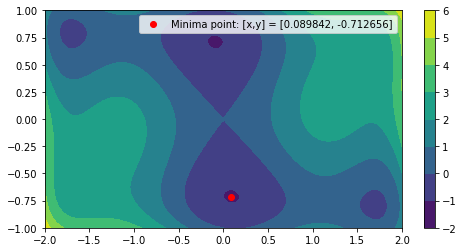

In [7]:
# x is from range -2 to 2
def f(x,y):
    return ((4 -2.1*x*x + ((x**4)/3))*x**2) + x*y + (4*y**2 - 4)*y**2

x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y) #X and Y meshgrid of shape(100 x 100)
#print(Y.shape)

Z=  f(X,Y) 

#plotting a 3d graph
fig, ax = plt.subplots(figsize=(8, 4))
contourmap = ax.contourf(x,y,Z)
fig.colorbar(contourmap)
ax.plot(ret1.x[0], ret1.x[1],'ro',label="Minima point: [x,y] = [%f, %f]"%(ret1.x[0],ret1.x[1]))
plt.legend()
plt.show()
#plt.imshow(Z)

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

/home/babak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


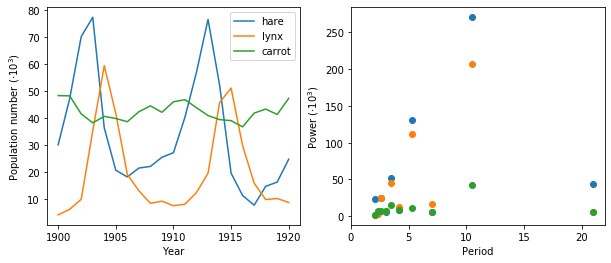

We see that there is a period of 10-11 years where the power becomes maximum and then finally comes down which is correct in prediction according the plot of populations versus years. 
We also know in general as omega and time are inversely proportional so does the population and power(abs(fft_population))


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Loading the data of populations
data = np.loadtxt('populations.txt')
years = data[:, 0]
populations = data[:, 1:] #years,hares,lynx,carrot

# Creating subplots side by side
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# plotting population vs years 
ax1.plot(years, populations * 1e-3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Population number ($\cdot10^3$)')
ax1.legend(['hare', 'lynx', 'carrot'], loc=1)

# Taking the Fast fourier Transform of the populations
from scipy import fftpack
# Fourier transform of the populations of hares, lynx and carrots along the columns of population matrix
ft_populations = fftpack.fft(populations, axis=0)

# The corresponding frequencies
n = populations.shape[0] #Window length.
time_step = years[1] - years[0] #Sample spacing (inverse of the sampling rate). 
frequencies = fftpack.fftfreq(n,time_step) #Array of length n containing the sample frequencies.
periods = 1 / frequencies

ax2.plot(periods, abs(ft_populations) * 1e-3, 'o') #abs(fft_signal) takes the absolute value of fft_signal since it is a complex dtype.
ax2.set_xlim(0, 22)
ax2.set_xlabel('Period')
ax2.set_ylabel('Power ($\cdot10^3$)')

plt.show()
print("We see that there is a period of 10-11 years where the power becomes maximum and then finally comes down which is correct in prediction according the plot of populations versus years. ")
print("We also know in general as omega and time are inversely proportional so does the population and power(abs(fft_population))")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

As we see, it contains a lot of noise and so the picture is not clear.


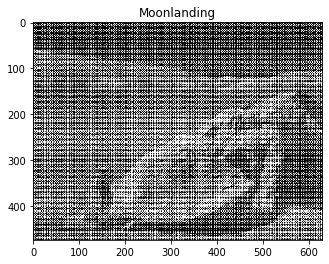

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

#Loading the image
moonlanding = plt.imread("moonlanding.png").astype(float)

#Seeing the loaded moonlanding image for the first time.
plt.imshow(moonlanding,plt.cm.gray)
plt.title("Moonlanding")
print("As we see, it contains a lot of noise and so the picture is not clear.")

The spectrum image when normalized is very clear and thus we can remove the higher values of power spectrum


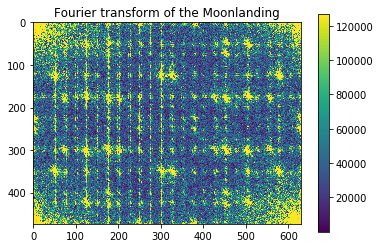

In [14]:
from scipy import fftpack
import matplotlib.colors

#2d fourier transform of the image
fft2D_moonlanding = fftpack.fft2(moonlanding) #This is of complex dtype
#print(fft2D_moonlanding)

#Converting it to power using np.abs() where complex part is being taken care of
power_moonlanding = abs(fft2D_moonlanding)
#print(power_moonlanding)

#plt.figure(figsize=(8,8))
def plot_spectrum(im_fft_absValue):
    from matplotlib.colors import Normalize
    #vmax corresponds to max value the data takes when normalized from 0 to 100 instead of the huge numbers
    vmax = 100
    norm = matplotlib.colors.Normalize(vmax=vmax)
    # We do this trick just to get the correct values of the colorbar without being normalized.
    img_withoutnorm = plt.imshow(im_fft_absValue); 
    img = plt.imshow(im_fft_absValue, norm=norm)
    plt.colorbar(img_withoutnorm)

plot_spectrum(power_moonlanding)
plt.title("Fourier transform of the Moonlanding")
print("The spectrum image when normalized is very clear and thus we can remove the higher values of power spectrum")

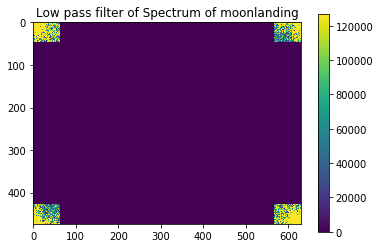

In [11]:
#Make a copy of the power_moonlanding
power_moonlanding_copy = power_moonlanding.copy()
rows, cols = power_moonlanding_copy.shape

#we will cut-off the middle square part of the spectrum as seen above by making them into 0. 
#We keep only the first few rows and first few columns
keep_fraction = 0.1

#Make the middle rows and columns as 0
power_moonlanding_copy[int(rows*keep_fraction):int(rows*(1-keep_fraction))] = 0
power_moonlanding_copy[:, int(cols*keep_fraction):int(cols*(1-keep_fraction))] = 0
plot_spectrum(power_moonlanding_copy)
plt.title("Low pass filter of Spectrum of moonlanding")

fft2D_moonlanding_copy = fft2D_moonlanding.copy()
zero_indices_array = np.argwhere(power_moonlanding_copy==0)

for i,j in zero_indices_array:
    fft2D_moonlanding_copy[i,j] = 0
#print(rows*keep_fraction)

Text(0.5, 1.0, 'Reconstructed Image')

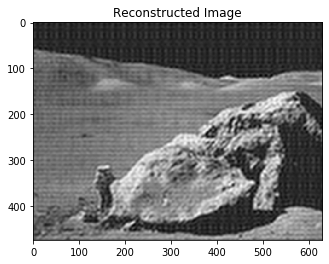

In [12]:
im_new = fftpack.ifft2(fft2D_moonlanding_copy).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')


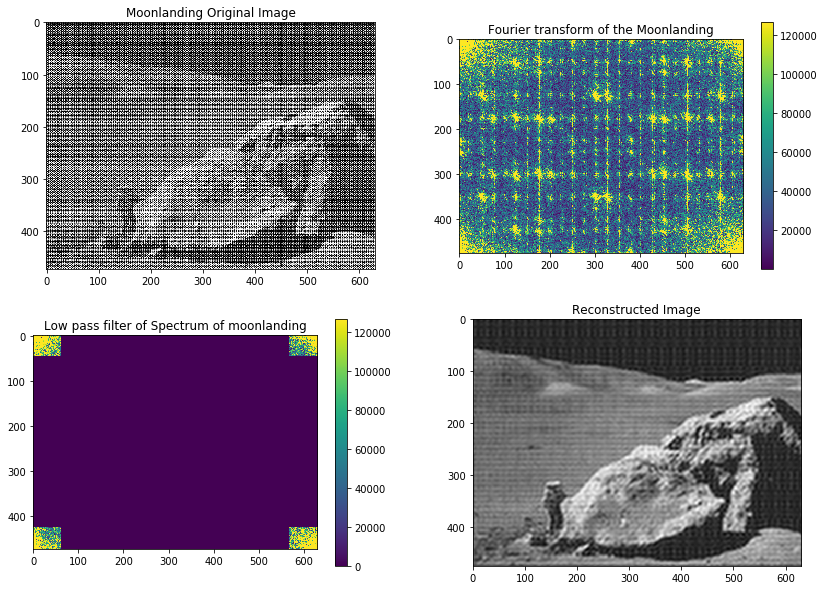

In [13]:
#Finally replotting everything for our comparison:
fig = plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.imshow(moonlanding,plt.cm.gray)
plt.title("Moonlanding Original Image")

plt.subplot(2,2,2)
plot_spectrum(power_moonlanding)
plt.title("Fourier transform of the Moonlanding")

plt.subplot(2,2,3)
plot_spectrum(power_moonlanding_copy)
plt.title("Low pass filter of Spectrum of moonlanding")

plt.subplot(2,2,4)
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

plt.show()
